In [1]:
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
import numpy as np
import scipy
from jax.config import config; config.update("jax_enable_x64", True)

from corner import corner, hist2d

import jaxopt

from tqdm import tqdm

import matplotlib.pyplot as plt

In [17]:
dims = 2
Nobs = 20

# Construct random posteriors
event_list = []
pdet = dist.Uniform(-3*jnp.ones(dims),3*jnp.ones(dims))

means = []
covs = []

for i in range(Nobs):
    cov = np.diag(np.random.uniform(0.01,0.5,size=dims))
    loc = np.random.randn(dims) + np.random.multivariate_normal(np.zeros(dims), cov)
    
    means.append(loc)
    covs.append(cov)
    
    dist_i = dist.MultivariateNormal(jnp.array(loc), jnp.array(cov))
    
    event_list.append(dist_i)

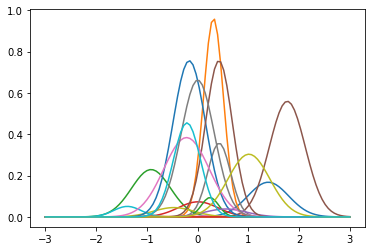

In [18]:
xs = np.linspace(-3,3,100)
ys = np.linspace(-3,3,100)
zs = np.zeros(100)

for i in range(Nobs):
    
    plt.plot(xs, np.exp(event_list[i].log_prob(jnp.array([xs,xs]).T)))
    
plt.show()

In [19]:
def log_Lstroke(pos_weight_array):
    
    pdet_term = - Nobs * jax.scipy.special.logsumexp(
        pdet.log_prob(pos_weight_array[:,:dims]).T + pos_weight_array[:,-1])

    data_term = jnp.array(0)
    for i in range(Nobs):
        data_term += jax.scipy.special.logsumexp(
            event_list[i].log_prob(pos_weight_array[:,:dims]) + pos_weight_array[:,-1])
    
    return pdet_term + data_term

def neg_log_Lstroke(pos_weight_array): return -log_Lstroke(pos_weight_array)

In [20]:
init_pistroke = jnp.atleast_2d(jnp.hstack([jax.random.uniform(key, minval=-3,maxval=3, shape=(int(Nobs),dims)), jnp.zeros((int(Nobs),1))]))
print(log_Lstroke(init_pistroke))

-79.49022835295986


In [21]:
opt_obj = jaxopt.GradientDescent(neg_log_Lstroke)
res = opt_obj.run(init_params=init_pistroke)
pistroke = res.params

In [22]:
print(log_Lstroke(pistroke))
res = opt_obj.run(init_params=pistroke)
pistroke = res.params
print(log_Lstroke(pistroke))

-27.798505677375843
-27.798505589670505


In [30]:
def construct_reduced_pistroke(pistroke, tol=1e-2, weight_min_level=1e-5):
    
    # Construct sorted pistroke
    sorted_pistroke = np.array(pistroke[pistroke[:, -1].argsort()[::-1]])
    
    # Construct reduced pistroke
    reduced_pistroke = []
    for i in range(len(sorted_pistroke)):
        matching_location = False
        matching_index = 0
        
        for j in range(len(reduced_pistroke)):
            if np.linalg.norm(sorted_pistroke[i,:-1] - reduced_pistroke[j][:-1]) < tol:
                matching_location = True
                matching_index = j
                break
                
        if matching_location:
            reduced_pistroke[matching_index][-1] = np.logaddexp(
                reduced_pistroke[matching_index][-1], sorted_pistroke[i,-1])
        else:
            reduced_pistroke.append(sorted_pistroke[i])
    
    reduced_pistroke = np.array(reduced_pistroke)
    
    reduced_pistroke[:,-1] -= scipy.special.logsumexp(reduced_pistroke[:,-1])
    reduced_pistroke = reduced_pistroke[reduced_pistroke[:,-1] > np.log(weight_min_level)]
    
    return reduced_pistroke

In [31]:
print(log_Lstroke(pistroke))
pistroke = construct_reduced_pistroke(pistroke)
res = opt_obj.run(init_params=pistroke)
pistroke = res.params
print(log_Lstroke(pistroke))

-27.797638802957053
-27.79763876583452


In [32]:
pistroke = construct_reduced_pistroke(pistroke)
print(log_Lstroke(pistroke))

-27.79763876583452


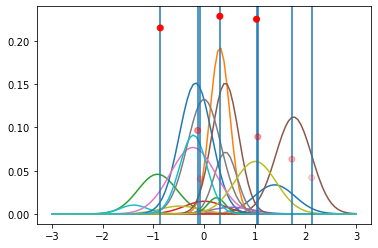

In [33]:
xs = np.linspace(-3,3,100)
ys = np.linspace(-3,3,100)
zs = np.zeros(100)

for i in range(Nobs):
    
    plt.plot(xs, np.exp(event_list[i].log_prob(jnp.array([xs]).T))/5)
    
plt.scatter(pistroke[:,0], np.exp(pistroke[:,-1])/np.sum(np.exp(pistroke[:,-1])),zorder=100, color='r', alpha=np.exp(pistroke[:,-1])/np.max(np.exp(pistroke[:,-1])))

for i in range(len(pistroke)):
    plt.axvline(pistroke[i,0])

plt.show()

(-4.0, 4.0)

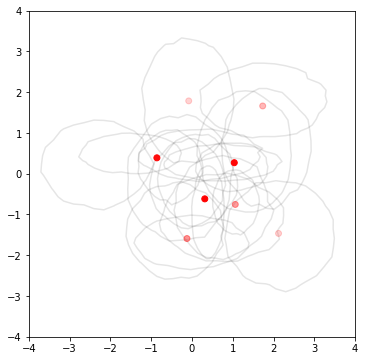

In [34]:
fig = plt.figure(figsize=[6,6])

for i in range(len(event_list)):
    samples = np.random.multivariate_normal(means[i], covs[i], size=10000)
    hist2d(samples[:,0], samples[:,1], new_fig=False, levels=[0.9], 
           smooth=0.5, plot_density=False, plot_datapoints=False, color='k', contour_kwargs={'alpha':0.1})

plt.scatter(pistroke[:,0], pistroke[:,1],zorder=100, color='r', 
            alpha=np.exp(pistroke[:,-1])/np.max(np.exp(pistroke[:,-1])))

ax = plt.gca()
ax.set_aspect('equal')
ax.set_ylim(-4,4)
ax.set_xlim(-4,4)

In [35]:
np.exp(pistroke[:,-1])

array([0.22851958, 0.22508787, 0.21504265, 0.09647483, 0.08908597,
       0.06323453, 0.04188161, 0.04067296])

In [36]:
pistroke

array([[ 0.31276114, -0.61640455, -1.47613339],
       [ 1.03635034,  0.27022851, -1.49126442],
       [-0.86182808,  0.39002329, -1.5369189 ],
       [-0.12441793, -1.58995135, -2.33847315],
       [ 1.06105303, -0.75357015, -2.41815343],
       [ 1.73332113,  1.66190241, -2.76090482],
       [ 2.12196881, -1.46456425, -3.17290834],
       [-0.08148629,  1.78664564, -3.2021917 ]])